# GeoPandas
> Pandas 地理工具包

## 导入工具包

In [2]:
import math
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPolygon

import folium
from folium import Choropleth, Circle, Marker, GeoJson
from folium.plugins import HeatMap, MarkerCluster

## 坐标转换

In [50]:
# -*- coding: utf-8 -*-
import json
import urllib
import math

x_pi = 3.14159265358979324 * 3000.0 / 180.0
pi = 3.1415926535897932384626  # π
a = 6378245.0  # 长半轴
ee = 0.00669342162296594323  # 偏心率平方


'''
输入（经度，维度）
'''
def bd09_to_gcj02(bd_lon, bd_lat):
    """
    百度坐标系(BD-09)转火星坐标系(GCJ-02)
    百度——>谷歌、高德
    :param bd_lat:百度坐标纬度
    :param bd_lon:百度坐标经度
    :return:转换后的坐标列表形式
    """
    x = bd_lon - 0.0065
    y = bd_lat - 0.006
    z = math.sqrt(x * x + y * y) - 0.00002 * math.sin(y * x_pi)
    theta = math.atan2(y, x) - 0.000003 * math.cos(x * x_pi)
    gg_lng = z * math.cos(theta)
    gg_lat = z * math.sin(theta)
    return [gg_lng, gg_lat]
def gcj02_to_wgs84(lng, lat):
    """
    GCJ02(火星坐标系)转GPS84
    :param lng:火星坐标系的经度
    :param lat:火星坐标系纬度
    :return:
    """
    if out_of_china(lng, lat):
        return [lng, lat]
    dlat = _transformlat(lng - 105.0, lat - 35.0)
    dlng = _transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return [lng * 2 - mglng, lat * 2 - mglat]
def bd09_to_wgs84(bd_lon, bd_lat):
    lon, lat = bd09_to_gcj02(bd_lon, bd_lat)
    return gcj02_to_wgs84(lon, lat)
def gcj02_to_bd09(lng, lat):
    """
    火星坐标系(GCJ-02)转百度坐标系(BD-09)
    谷歌、高德——>百度
    :param lng:火星坐标经度
    :param lat:火星坐标纬度
    :return:
    """
    z = math.sqrt(lng * lng + lat * lat) + 0.00002 * math.sin(lat * x_pi)
    theta = math.atan2(lat, lng) + 0.000003 * math.cos(lng * x_pi)
    bd_lng = z * math.cos(theta) + 0.0065
    bd_lat = z * math.sin(theta) + 0.006
    return [bd_lng, bd_lat]
def wgs84_to_gcj02(lng, lat):
    """
    WGS84转GCJ02(火星坐标系)
    :param lng:WGS84坐标系的经度
    :param lat:WGS84坐标系的纬度
    :return:
    """
    if out_of_china(lng, lat):  # 判断是否在国内
        return [lng, lat]
    dlat = _transformlat(lng - 105.0, lat - 35.0)
    dlng = _transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return [mglng, mglat]
def wgs84_to_bd09(lon, lat):
    lon, lat = wgs84_to_gcj02(lon, lat)
    return gcj02_to_bd09(lon, lat)

def out_of_china(lng, lat):
    """
    判断是否在国内，不在国内不做偏移
    :param lng:
    :param lat:
    :return:
    """
    return not (lng > 73.66 and lng < 135.05 and lat > 3.86 and lat < 53.55)

def _transformlng(lng, lat):
    ret = 300.0 + lng + 2.0 * lat + 0.1 * lng * lng + \
          0.1 * lng * lat + 0.1 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *
            math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lng * pi) + 40.0 *
            math.sin(lng / 3.0 * pi)) * 2.0 / 3.0
    ret += (150.0 * math.sin(lng / 12.0 * pi) + 300.0 *
            math.sin(lng / 30.0 * pi)) * 2.0 / 3.0
    return ret
def _transformlat(lng, lat):
    ret = -100.0 + 2.0 * lng + 3.0 * lat + 0.2 * lat * lat + \
          0.1 * lng * lat + 0.2 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *
            math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lat * pi) + 40.0 *
            math.sin(lat / 3.0 * pi)) * 2.0 / 3.0
    ret += (160.0 * math.sin(lat / 12.0 * pi) + 320 *
            math.sin(lat * pi / 30.0)) * 2.0 / 3.0
    return ret


## 示例

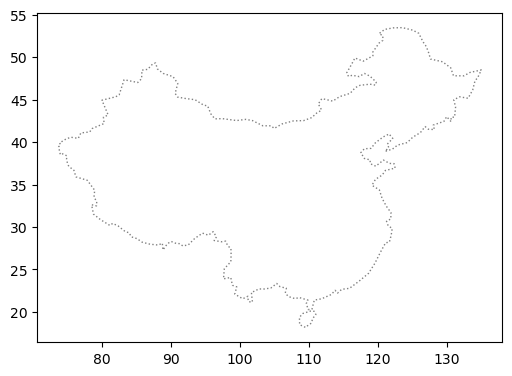

In [4]:
# 画国家的边境线
# alpha 透明度
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
china = world.loc[world.name.str.contains('China')]
ax = china.plot(figsize=(6, 6), color='white',
                linestyle=':', edgecolor='gray')
# path.plot(ax=ax, color='red', markersize=30, alpha=0.4)
# 根据Point画出Line

## 交互式地图

### 初始化交互地图

注意： 中国的规则是先经度(lng)再维度(lat)，外国是先维度再经度

In [100]:
# 天府广场,104.072425,30.663503,四川省成都市锦江区人民南路一段86号
ct_lon, ct_lat = bd09_to_wgs84(104.072425, 30.663503)

# 成都市郫都区博物馆, 103.879885, 30.814631, 望丛中路5号
lon, lat = bd09_to_wgs84(103.879885, 30.814631)

# Create a map
m_1 = folium.Map(location=[ct_lat, ct_lon],
                 tiles='openstreetmap', zoom_start=10)
Marker([lat, lon]).add_to(m_1)
Marker([ct_lat, ct_lon]).add_to(m_1)
# Display the map
m_1

### 准备坐标数据

In [6]:
citys = pd.DataFrame({'Name': ['北京', '成都'], 'Latitude': [
                     39.877454, 30.571925], 'Longitude': [116.390760, 104.081128]}, index=['bj', 'cd'])
citys

,Name,Latitude,Longitude
bj,北京,39.877454,116.390760
cd,成都,30.571925,104.081128


In [7]:
landscapes_data = [
    ['黄龙溪', 103.97, 30.32, 1],
    ['黑龙滩景区', 104.04, 30.07, 1],
    ['三岔湖景区', 104.27, 30.28, 1],
    ['珍珠湖景区', 115.77, 40.08, 1],
    ['金顶妙峰景区', 116.02, 40.06, 1],
    ['猫耳山', 115.88, 39.74, 1],
    ['金沙遗址博物馆', 104.01, 30.68, 1],
    ['石人公园', 104.03, 30.68, 1],
    ['清水河公园', 103.99, 30.66, 1]
]

landscapes = pd.DataFrame(landscapes_data, columns=['Name','Longitude','Latitude','Priority'])
landscapes

,Name,Longitude,Latitude,Priority
0,黄龙溪,103.97,30.32,1
1,黑龙滩景区,104.04,30.07,1
2,三岔湖景区,104.27,30.28,1
3,珍珠湖景区,115.77,40.08,1
4,金顶妙峰景区,116.02,40.06,1
5,猫耳山,115.88,39.74,1
6,金沙遗址博物馆,104.01,30.68,1
7,石人公园,104.03,30.68,1
8,清水河公园,103.99,30.66,1


### 标记地图上的点
使用Marker或者MarkerCluster标记地图上的点

In [9]:
for idx, row in citys.iterrows():
	Marker([row.Latitude, row.Longitude]).add_to(m_1)
m_1

In [8]:
mc = MarkerCluster()
for idx, row in landscapes.iterrows():
	mc.add_child(Marker([row.Latitude, row.Longitude]))

m_1.add_child(mc)
m_1

### 使用气泡(圆圈)标记

In [9]:
def color_producer(val):
	if val == 1:
		return 'forestgreen'
	elif val == 2:
		return 'darkred'
	else:
		return 'black'

for i in range(0, len(landscapes)):
	Circle(location=[landscapes.iloc[i].Latitude, landscapes.iloc[i].Longitude], 
				radius=20, 
				color=color_producer(landscapes.iloc[i].Priority)).add_to(m_1)

m_1

### 热力图
示例：博物馆附件，树夏奶茶店密度如何？

In [56]:
museum = pd.read_csv('./data/museum.csv')


def bd_to_wgs(row):
	nlng, nlat = bd09_to_wgs84(row.lng, row.lat)
	row.lng = nlng
	row.lat = nlat
	return row

museum_up1 = museum.apply(bd_to_wgs, axis='columns')
museum.update(museum_up1)
museum


,name,lng,lat,address
0,成都博物馆新馆-检票-出入口,104.061263,30.659454,小河街1号成都博物馆新馆内
1,成都博物馆新馆,104.061141,30.659717,四川省成都市青羊区小河街1号
2,四川博物院,104.031690,30.663275,四川省成都市青羊区浣花南路251号
3,成都金沙遗址博物馆,104.010292,30.684241,成都市青羊区金沙遗址路2号
4,成都武侯祠博物馆,104.045677,30.648752,四川省成都市武侯区武侯祠大街231号
...,...,...,...,...
146,中国文化遗产永久纪念标志雕塑(金沙遗址),104.009778,30.683228,成都市青羊区金沙遗址路2号
147,日本侵华罪行馆,103.618932,30.505447,成都市大邑县安仁镇大新路建川博物馆聚落旅游区
148,庄园文物珍品馆,103.625925,30.508734,成都市大邑县安仁镇金桂街15号大邑刘氏庄园博物馆内
149,国防兵器馆,103.615637,30.501766,成都市大邑县安仁古镇迎宾路80号(近金桂公馆酒店)建川博物馆聚落内


In [57]:
shuxia = pd.read_csv('./data/shuxia.csv')
shuxia_clean = shuxia[shuxia.name.str.contains('树夏')]
shuxia_clean_up1 = shuxia_clean.apply(bd_to_wgs, axis='columns')

shuxia_clean.update(shuxia_clean_up1)
shuxia_clean


/var/folders/5s/hp2lrr6s28dcft7pjdnx9w3c0000gn/T/ipykernel_47514/3399619103.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuxia_clean.update(shuxia_clean_up1)
/var/folders/5s/hp2lrr6s28dcft7pjdnx9w3c0000gn/T/ipykernel_47514/3399619103.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuxia_clean.update(shuxia_clean_up1)
/var/folders/5s/hp2lrr6s28dcft7pjdnx9w3c0000gn/T/ipykernel_47514/3399619103.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,name,lng,lat,address
0,树夏·生榨鲜果茶(建设路店),104.100106,30.673500,四川省成都市成华区建设中路15号
1,树夏(金色校园广场店),103.988272,30.552420,四川省成都市双流区长城路二段481号
2,树夏·生榨鲜果茶(二十四城店),104.114278,30.646932,四川省成都市成华区双成三路15号附73号
3,树夏(成都银泰城店),104.055916,30.543206,四川省成都市高新区益州大道中段1999号成都银泰城F1
4,树夏(中铁西城·新天地店),103.961454,30.675871,四川省成都市青羊区光华东二路98号中铁西城·新天地F1
...,...,...,...,...
72,树夏生榨鲜果茶(文殊坊店),104.070242,30.674564,四川省成都市青羊区楞伽庵街4号
73,树夏美甲美睫,103.969578,30.806268,成都市郫都区蜀源大道府河别样城
74,树夏生榨鲜果茶(北城天街店),104.062576,30.711269,四川省成都市金牛区五块石车北城天街b1层90号
75,树夏花开(三圣乡店),104.130770,30.588918,幸福联合五组147号附1号


In [58]:
# Create a map
m_2 = folium.Map(location=[30.571925, 104.081128],
                 tiles='openstreetmap', zoom_start=10)
# Display the map
HeatMap(data=shuxia_clean[['lat', 'lng']], radius=10).add_to(m_2)


def get_popup(name, address):
	html = "<span>{}</span></br><p>地址：{}</p>".format(name,address)
	iframe = folium.IFrame(html)
	popup = folium.Popup(iframe,min_width=200,max_width=200)
	return popup

mc = MarkerCluster()
for idx, row in museum.iterrows():
	mc.add_child(Marker([row.lat, row.lng], popup=get_popup(row['name'], row['address'])))

mc.add_to(m_2)

m_2

### 坐标映射

In [62]:
museum_geo = gpd.GeoDataFrame(museum, geometry=gpd.points_from_xy(museum.lng, museum.lat))
museum_geo.crs = {'init': 'epsg:4326'}
museum_geo.head()

/Users/hawkins/opt/anaconda3/envs/analysis/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,name,lng,lat,address,geometry
0,成都博物馆新馆-检票-出入口,104.061263,30.659454,小河街1号成都博物馆新馆内,POINT (104.06126 30.65945)
1,成都博物馆新馆,104.061141,30.659717,四川省成都市青羊区小河街1号,POINT (104.06114 30.65972)
2,四川博物院,104.031690,30.663275,四川省成都市青羊区浣花南路251号,POINT (104.03169 30.66328)
3,成都金沙遗址博物馆,104.010292,30.684241,成都市青羊区金沙遗址路2号,POINT (104.01029 30.68424)
4,成都武侯祠博物馆,104.045677,30.648752,四川省成都市武侯区武侯祠大街231号,POINT (104.04568 30.64875)


In [63]:
shuxia_clean_geo = gpd.GeoDataFrame(shuxia_clean, geometry=gpd.points_from_xy(shuxia_clean.lng, shuxia_clean.lat))
shuxia_clean_geo.crs = {'init': 'epsg:4326'}
shuxia_clean_geo.head()

/Users/hawkins/opt/anaconda3/envs/analysis/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,name,lng,lat,address,geometry
0,树夏·生榨鲜果茶(建设路店),104.100106,30.673500,四川省成都市成华区建设中路15号,POINT (104.10011 30.67350)
1,树夏(金色校园广场店),103.988272,30.552420,四川省成都市双流区长城路二段481号,POINT (103.98827 30.55242)
2,树夏·生榨鲜果茶(二十四城店),104.114278,30.646932,四川省成都市成华区双成三路15号附73号,POINT (104.11428 30.64693)
3,树夏(成都银泰城店),104.055916,30.543206,四川省成都市高新区益州大道中段1999号成都银泰城F1,POINT (104.05592 30.54321)
4,树夏(中铁西城·新天地店),103.961454,30.675871,四川省成都市青羊区光华东二路98号中铁西城·新天地F1,POINT (103.96145 30.67587)


### 测量地图上的距离

In [65]:
# 球面坐标系转换为平面坐标系才能计算距离
shuxia_clean_geo = shuxia_clean_geo.to_crs(crs=3857)
museum_geo = museum_geo.to_crs(crs=3857)  

# 随意选一个树夏店
first_shuxia = shuxia_clean_geo.iloc[0]

# 测量这个店铺和各个博物馆的距离
distances = museum_geo.geometry.distance(first_shuxia.geometry)
distances

0       4690.531547
1       4690.036688
2       7730.155755
3      10094.290201
4       6853.428147
           ...     
146    10133.841585
147    57804.720507
148    56923.835235
149    58324.216967
150    31908.740474
Length: 151, dtype: float64

In [70]:
min_museum = museum_geo.iloc[distances.idxmin()]

print('离:{}, 最近的博物馆是：{} 距离: {} 米'.format(first_shuxia['name'],
      min_museum['name'], math.floor(distances.min())))


离:树夏·生榨鲜果茶(建设路店), 最近的博物馆是：天府四川金融博物馆 距离: 1047 米


In [75]:
m_3 = folium.Map(location=[min_museum.lat,min_museum.lng], tiles='OpenStreetMap', zoom_start=15)
Marker([min_museum.lat, min_museum.lng], popup=min_museum['name']).add_to(m_3)
Marker([first_shuxia.lat, first_shuxia.lng], popup=first_shuxia['name']).add_to(m_3)

m_3

### 创建缓冲区

那些博物馆的30km内都没有树夏奶茶店？

In [110]:
# 画30km的圆
two_mile_buffer = shuxia_clean_geo.geometry.buffer(2000)

# 合并这些园
union_buffer = two_mile_buffer.geometry.unary_union

outside_range = museum_geo.loc[~museum_geo.geometry.apply(lambda x: union_buffer.contains(x))]

outside_range.head()


,name,lng,lat,address,geometry
2,四川博物院,104.031690,30.663275,四川省成都市青羊区浣花南路251号,POINT (11580754.776 3589095.809)
6,成都杜甫草堂博物馆,104.026016,30.662642,四川省成都市青羊区青华路37号,POINT (11580123.110 3589013.797)
7,刘氏庄园博物馆,103.625428,30.508055,四川省成都市大邑县安仁镇金桂街15号,POINT (11535529.840 3569024.162)
8,四川建川博物馆聚落,103.617294,30.503007,成都市大邑县安仁镇迎宾路,POINT (11534624.424 3568371.968)
10,泰迪熊博物馆,103.795300,30.640290,四川省成都市温江区金湖大道299号,POINT (11554439.916 3586121.497)


### 那家店的需求最高
找到所有树夏店中到博物馆的最小距离的店


In [111]:
# Create a map
m_3 = folium.Map(location=[30.571925, 104.081128],
                 tiles='openstreetmap', zoom_start=11)


def best_shuxia(museum_loc):
	idx_min = shuxia_clean_geo.geometry.distance(museum_loc).idxmin()
	sx = shuxia_clean_geo.iloc[idx_min]
	return sx['name']


highest_demand = outside_range.geometry.apply(best_shuxia).value_counts().idxmax()

highest_demand

'树夏(温江财大店)'

### 选择哪儿?
展示所有当前店铺的位置，以及离这些位置超过10km的博物馆

In [112]:
# 以天府广场为中心
m_4 = folium.Map(location=[ct_lat,ct_lon], tiles='OpenStreetMap', zoom_start=11)
coverage = gpd.GeoDataFrame(geometry=shuxia_clean_geo.geometry).buffer(2000)
folium.GeoJson(coverage.geometry.to_crs(epsg=4326)).add_to(m_4) # 要画图需要先把坐标转换回来
HeatMap(data=outside_range[['lat','lng']], radius=9).add_to(m_4)
folium.LatLngPopup().add_to(m_4)

m_4